# Single Image Player Detector

In [1]:
import requests
import cv2
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import datetime
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import numpy as np


In [2]:
model_id = "IDEA-Research/grounding-dino-tiny" # HF
device = "cuda"
processor = AutoProcessor.from_pretrained(model_id) # image processor
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
image_path = "/content/synframe99_jpg.rf.3823fb2e88b312d9ad1d67f56d705adc.jpg"
image = Image.open(image_path)
text_labels = [["tennis player", "tennis court"]] #, "a tennis ball"


In [ ]:
inputs = processor (
    images = image.convert("RGB"),
    text = text_labels,
    return_tensors = "pt").to(device)
with torch.no_grad():
    outputs = model (**inputs)


In [ ]:
results = processor.post_process_grounded_object_detection (
    outputs,
    inputs.input_ids,
    # threshold = 0.3,
    text_threshold = 0.3,
    target_sizes = [image.size[::-1]]
)


In [ ]:
results[0]

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


{'scores': tensor([0.5998, 0.5497, 0.4629, 0.3796], device='cuda:0'),
 'boxes': tensor([[ 435.8917,  390.0420,  495.2908,  528.8397],
         [ 812.2004,   79.6066,  857.8285,  143.4861],
         [   2.7755,   86.9176, 1276.3354,  715.4844],
         [ 209.2658,  151.6560, 1089.2329,  586.4394]], device='cuda:0'),
 'text_labels': ['tennis player',
  'tennis player',
  'tennis court',
  'tennis court'],
 'labels': ['tennis player', 'tennis player', 'tennis court', 'tennis court']}

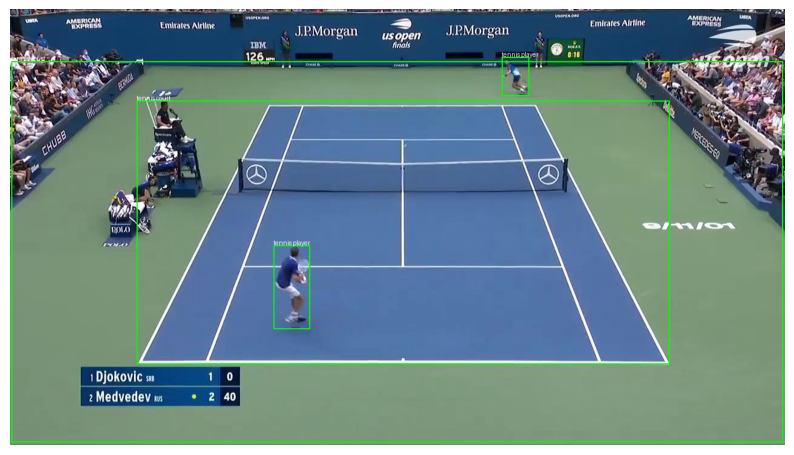

In [ ]:
draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)

result = results[0]

for box, label in zip(result["boxes"], result["text_labels"]):
  box = [int(x) for x in box.tolist()]
  draw.rectangle (box, outline=(0, 255, 0), width=2)
  try:
      font = ImageFont.truetype("arial.ttf", size=24)
  except:
      font = ImageFont.load_default() # Fallback to default font
  draw.text ((box[0], box[1] - 10), label, fill=(255, 255, 255))

plt.figure(figsize=(10, 10))
plt.imshow(draw_image)
plt.axis('off')
plt.show()


# Full Video Player Detector

In [3]:
def player_detections(frame):

  image = Image.fromarray(frame)

  text_labels = ["tennis player"]
  inputs = processor(
    images = image.convert("RGB"), text=text_labels, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = model(**inputs)

  results = processor.post_process_grounded_object_detection (
    outputs,
    inputs.input_ids,
    text_threshold = 0.3,
    target_sizes = [image.size[::-1]]
  )

  result = results[0]
  preds = []

  for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    if labels in text_labels:
      box = [int(x) for x in box.tolist()]
      preds.append([[box[0], box[1], box[2], box[3]], score.item(), 1])

  return preds


In [4]:
video_path = "/content/video_test.mp4"
output_video_path = "output_video_player_det_2.mp4"

video_cap = cv2.VideoCapture(video_path)

frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


In [5]:
while video_cap.isOpened():

    start = datetime.datetime.now()
    ret, frame = video_cap.read()
    if not ret: break

    player_bbox = player_detections (frame)
    print(f"Number of dtections = {len(player_bbox)}")

    if len(player_bbox) > 0:
      for p in player_bbox:
        xmin = int(p[0][0])
        ymin = int(p[0][1])
        xmax = int(p[0][2])
        ymax = int(p[0][3])
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)
        cv2.putText(frame, "player", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

      writer.write(frame)
      end = datetime.datetime.now()
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} miliseconds")

video_cap.release()
writer.release()
cv2.destroyAllWindows()
